# Aerial Object Classification & Detection  
## Custom CNN Classification (Bird vs Drone)

This notebook covers:

1. Environment & data pipeline setup (reusing Phase 2 settings)  
2. Custom CNN architecture definition  
3. Model compilation & callbacks  
4. Training with class weights  
5. Evaluation on test data (metrics + confusion matrix)  
6. Saving best model

##Basic Imports

In [1]:
# Import all required libraries for building, training and evaluating CNN models.

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Mount Drive & Set Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Base paths

In [ ]:
#Define the base project directory paths

BASE_DIR = "/content/drive/MyDrive/Project-2/Aerial_Object_Classification_Detection"
CLASSIFICATION_DIR = os.path.join(BASE_DIR, "data", "classification_dataset")

print("Base directory:", BASE_DIR)
print("Classification dataset:", CLASSIFICATION_DIR)

Base directory: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection
Classification dataset: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset


## Recreate Data Generator
We'll rebuild the train/val/test generators so this notebook is self-contained.

In [4]:
# Define constants for image dimensions and batch size
# These values will be used for resizing and batching images.

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Define paths for training, validation and test sets
train_dir = os.path.join(CLASSIFICATION_DIR, "train")
valid_dir   = os.path.join(CLASSIFICATION_DIR, "valid")
test_dir  = os.path.join(CLASSIFICATION_DIR, "test")

print("Train:", train_dir)
print("Valid:", valid_dir)
print("Test:", test_dir)

Train: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset/train
Valid: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset/valid
Test: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset/test


Data augmentation for training

In [5]:
# Augmentations help improve model generalization by generating new variations of images.

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=25,           # Randomly rotate images up to ±25 degrees
    width_shift_range=0.15,      # Shift horizontally by 15%
    height_shift_range=0.15,     # Shift vertically by 15%
    zoom_range=0.2,              # Randomly zoom in/out
    shear_range=0.15,            # Shear transformations
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.7, 1.3], # Random brightness variation
    fill_mode='nearest'          # Fill missing pixels after transformations
)

# Validation and test sets only require normalization (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Build generators to load and preprocess images in batches

In [6]:
# flow_from_directory() automatically labels images based on folder names.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',     # Binary classification (Bird vs Drone)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Print class indices mapping (should be {'bird':0, 'drone':1})
print("Class indices:", train_generator.class_indices)

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


Compute Class Weights (Loading saved one)

In [7]:
#Load previously saved class weights instead of recomputing
# We'll look for the saved file under your project's 'config' or 'models' folder.
# If not found, the code falls back to recomputing them automatically.

import numpy as np
import json
from sklearn.utils.class_weight import compute_class_weight

# Define the expected file path for stored class weights
weights_file = os.path.join(BASE_DIR, "config", "class_weights.json")

# Check if the file exists
if os.path.exists(weights_file):
    # Load previously saved weights
    with open(weights_file, "r") as f:
        class_weights_dict = json.load(f)
    print("✅ Loaded class weights from file:", weights_file)
else:
    print("⚠️ class_weights.json not found — recomputing from training generator.")

    # Extract labels from the train generator
    labels = train_generator.classes  # 0 = bird, 1 = drone

    # Compute class weights (balanced = inverse of frequency)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )

    # Convert to dictionary and save for reuse
    class_weights_dict = dict(enumerate(class_weights))

    # Save weights for future use
    os.makedirs(os.path.join(BASE_DIR, "config"), exist_ok=True)
    with open(weights_file, "w") as f:
        json.dump(class_weights_dict, f)
    print("✅ Computed and saved class weights to:", weights_file)

# Display final weights
print("Final Class Weights:", class_weights_dict)

✅ Loaded class weights from file: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/config/class_weights.json
Final Class Weights: {'0': 0.9413012729844413, '1': 1.0665064102564104}


## Define Custom CNN Architecture
A moderately deep CNN with:
- Conv → BatchNorm → ReLU → MaxPool blocks  
- Dropout to prevent overfitting  
- Global average pooling for efficient feature extraction  
- Sigmoid output for binary classification

Custom CNN architecture definition

In [8]:
def build_custom_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """Builds a custom CNN model for Bird vs Drone classification."""

    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Optional Block 4 – adds depth for more complex features
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Feature aggregation and fully connected layers
    x = layers.GlobalAveragePooling2D()(x)     # Reduces each feature map to one value
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer – single neuron with sigmoid activation for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="custom_cnn_bird_drone")
    return model

# Build and display model summary
model = build_custom_cnn()
model.summary()

Model: "custom_cnn_bird_drone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 431,553 (1.65 MB)

 Trainable params: 430,593 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile the Model
We’ll track: accuracy, precision, recall, and AUC to assess performance.

In [9]:
# Model compilation

# Define metrics to monitor during training
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
]

# Compile model using Adam optimizer and binary crossentropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

## Define Callbacks
Callbacks improve training efficiency:
- `EarlyStopping`: Stop when validation loss stops improving  
- `ReduceLROnPlateau`: Lower learning rate when stuck  
- `ModelCheckpoint`: Save best model weights

In [10]:
# Define callbacks for training stability and optimization

models_dir = os.path.join(BASE_DIR, "models")
os.makedirs(models_dir, exist_ok=True)

# Save best weights to this file
checkpoint_path = os.path.join(models_dir, "custom_cnn_best.keras")

# Stop training when validation loss hasn't improved for 7 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Reduce learning rate by 0.3 if val_loss doesn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Save model weights whenever val_loss improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

## 7. Train the Model

In [11]:
EPOCHS = 40  # upper limit, EarlyStopping will usually stop earlier

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights_dict,  # handle imbalance
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5918 - auc: 0.6306 - loss: 0.7173 - precision: 0.5810 - recall: 0.5306
Epoch 1: val_loss improved from inf to 0.60848, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/custom_cnn_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 747s 9s/step - accuracy: 0.5923 - auc: 0.6313 - loss: 0.7165 - precision: 0.5816 - recall: 0.5310 - val_accuracy: 0.6584 - val_auc: 0.7343 - val_loss: 0.6085 - val_precision: 0.7229 - val_recall: 0.5333 - learning_rate: 0.0010
Epoch 2/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7146 - auc: 0.7776 - loss: 0.5675 - precision: 0.7335 - recall: 0.6564
Epoch 2: val_loss did not improve from 0.60848
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 570ms/step - accuracy: 0.7146 - auc: 0.7776 - loss: 0.5675 - precision: 0.7334 - recall: 0.6561 - val_accuracy: 0.6833 - val_auc: 0.7461 - val_loss: 0.6361 - val_precision: 0.7673 - val_recall: 0.5422 - learning_rate: 0.0010
Epoch

## 8. Plot Training Curves (Loss & Accuracy)
Visualize model learning trends to detect overfitting or underfitting.

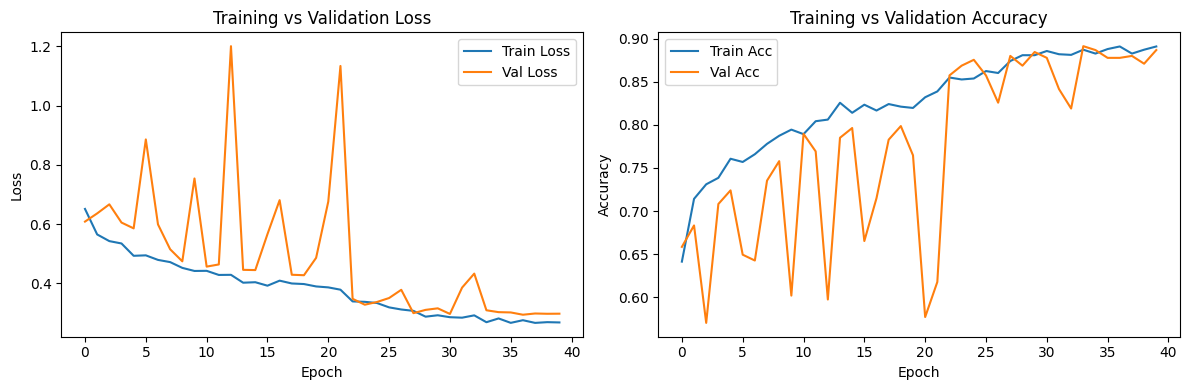

In [12]:
#Plot training history for quick analysis

def plot_training_history(history):
    """Plots training and validation loss/accuracy curves."""
    hist = history.history

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## 9. Evaluate on Test Set
We’ll load best weights, evaluate metrics, and compute predictions.

In [13]:
# Load best model weights saved during training
# Ensures we evaluate the best-performing version of the model.

model.load_weights(checkpoint_path)
print("Loaded best weights from:", checkpoint_path)

Loaded best weights from: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/custom_cnn_best.keras


In [21]:
# Evaluate model on test dataset
# Prints key performance metrics such as accuracy, precision, recall, AUC.

test_metrics = model.evaluate(test_generator, verbose=1)
metric_names = model.metrics_names

for name, value in zip(metric_names, test_metrics):
    print(f"{name}: {value:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.9524 - auc: 0.6113 - loss: 0.1923 - precision: 0.5225 - recall: 0.5808
loss: 0.2405
compile_metrics: 0.9209


### 9.1 Predictions & Confusion Matrix
Visualize misclassifications and overall performance.

In [15]:
# Generate predictions on the test dataset

# Predict probabilities (values between 0 and 1)
y_prob = model.predict(test_generator, verbose=1).ravel()

# Convert probabilities to binary predictions using 0.5 threshold
y_pred = (y_prob >= 0.5).astype(int)

# True labels from generator
y_true = test_generator.classes

# Inverse class mapping (e.g., 0→bird, 1→drone)
class_indices = test_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
print("Class mapping:", inv_class_indices)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step
Class mapping: {0: 'bird', 1: 'drone'}


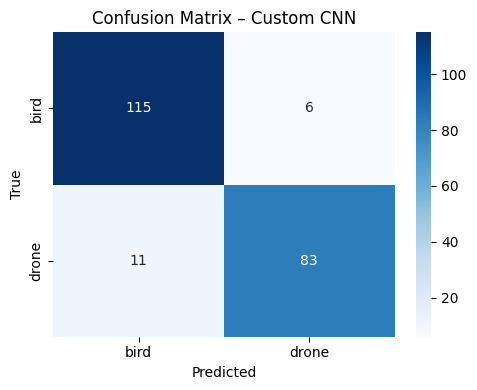

In [28]:
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=[inv_class_indices[0], inv_class_indices[1]]
))

Classification Report:

              precision    recall  f1-score   support

        bird       0.91      0.95      0.93       121
       drone       0.93      0.88      0.91        94

    accuracy                           0.92       215
   macro avg       0.92      0.92      0.92       215
weighted avg       0.92      0.92      0.92       215



In [29]:
# Compute and print detailed evaluation metrics
# ------------------------------------------------------------
# This block extracts values from the classification report dictionary
# and prints them in a more readable, summarized format.

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute metrics again as dictionary (so we can access the numbers directly)
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=[inv_class_indices[0], inv_class_indices[1]],
    output_dict=True
)


# Compute overall accuracy separately
overall_accuracy = accuracy_score(y_true, y_pred)

# Extract metrics for each class
bird_precision = report_dict[inv_class_indices[0]]['precision']
bird_recall    = report_dict[inv_class_indices[0]]['recall']
bird_f1        = report_dict[inv_class_indices[0]]['f1-score']

drone_precision = report_dict[inv_class_indices[1]]['precision']
drone_recall    = report_dict[inv_class_indices[1]]['recall']
drone_f1        = report_dict[inv_class_indices[1]]['f1-score']

# Extract weighted/overall averages
weighted_precision = report_dict['weighted avg']['precision']
weighted_recall    = report_dict['weighted avg']['recall']
weighted_f1        = report_dict['weighted avg']['f1-score']

# Print in organized format
print("🔍 Detailed Evaluation Metrics")
print("=======================================")
print(f"✅ Overall Accuracy: {overall_accuracy:.4f}")
print("---------------------------------------")
print(f"🕊️ Bird Class (Label: {inv_class_indices[0]})")
print(f"   Precision : {bird_precision:.4f}")
print(f"   Recall    : {bird_recall:.4f}")
print(f"   F1-Score  : {bird_f1:.4f}")
print("---------------------------------------")
print(f"🚁 Drone Class (Label: {inv_class_indices[1]})")
print(f"   Precision : {drone_precision:.4f}")
print(f"   Recall    : {drone_recall:.4f}")
print(f"   F1-Score  : {drone_f1:.4f}")
print("---------------------------------------")
print(f"📊 Weighted Average (Overall)")
print(f"   Precision : {weighted_precision:.4f}")
print(f"   Recall    : {weighted_recall:.4f}")
print(f"   F1-Score  : {weighted_f1:.4f}")
print("=======================================")


{'bird': {'precision': 0.9126984126984127, 'recall': 0.9504132231404959, 'f1-score': 0.9311740890688259, 'support': 121.0}, 'drone': {'precision': 0.9325842696629213, 'recall': 0.8829787234042553, 'f1-score': 0.907103825136612, 'support': 94.0}, 'accuracy': 0.9209302325581395, 'macro avg': {'precision': 0.922641341180667, 'recall': 0.9166959732723756, 'f1-score': 0.919138957102719, 'support': 215.0}, 'weighted avg': {'precision': 0.9213926943480117, 'recall': 0.9209302325581395, 'f1-score': 0.9206503457682301, 'support': 215.0}}
🔍 Detailed Evaluation Metrics
✅ Overall Accuracy: 0.9209
---------------------------------------
🕊️ Bird Class (Label: bird)
   Precision : 0.9127
   Recall    : 0.9504
   F1-Score  : 0.9312
---------------------------------------
🚁 Drone Class (Label: drone)
   Precision : 0.9326
   Recall    : 0.8830
   F1-Score  : 0.9071
---------------------------------------
📊 Weighted Average (Overall)
   Precision : 0.9214
   Recall    : 0.9209
   F1-Score  : 0.9207


## 10. Save Final Model (Optional Separate Copy)
Save the complete model (architecture + weights) for easy reuse.

In [18]:
# Save the full trained model (architecture + weights)
# This is useful if you want to load the model later without rebuilding architecture.

final_model_path = os.path.join(models_dir, "custom_cnn_final_full_model.keras")
model.save(final_model_path)
print("Full model saved to:", final_model_path)

Full model saved to: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/custom_cnn_final_full_model.keras
